In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
df = pd.read_excel(r"C:\Users\Desktop\Agro.xlsx")

In [3]:
df.columns

Index(['Unnamed: 0', 'Title', 'labels'], dtype='object')

In [4]:
df1 = df[['Title', 'labels']].copy()

In [5]:
df1.head()

,Title,labels
0,Pesticidally active cyclic amine compounds,insecticide
1,Pest control composition and control method,insecticide
2,Method for controlling pests,insecticide
3,Compositions for controlling deleterious arthr...,insecticide
4,Insect Control Composition,insecticide


In [6]:
pd.DataFrame(df1.labels.unique()).values

array([['insecticide'],
       ['herbicide'],
       ['fungicide'],
       ['miscellaneous']], dtype=object)

In [7]:
# Create a new column 'category_id' with encoded categories 
df1['category_id'] = df1['labels'].factorize()[0]
category_id_df = df1[['labels', 'category_id']].drop_duplicates()

In [8]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'labels']].values)
# New dataframe
df1.head()

,Title,labels,category_id
0,Pesticidally active cyclic amine compounds,insecticide,0
1,Pest control composition and control method,insecticide,0
2,Method for controlling pests,insecticide,0
3,Compositions for controlling deleterious arthr...,insecticide,0
4,Insect Control Composition,insecticide,0


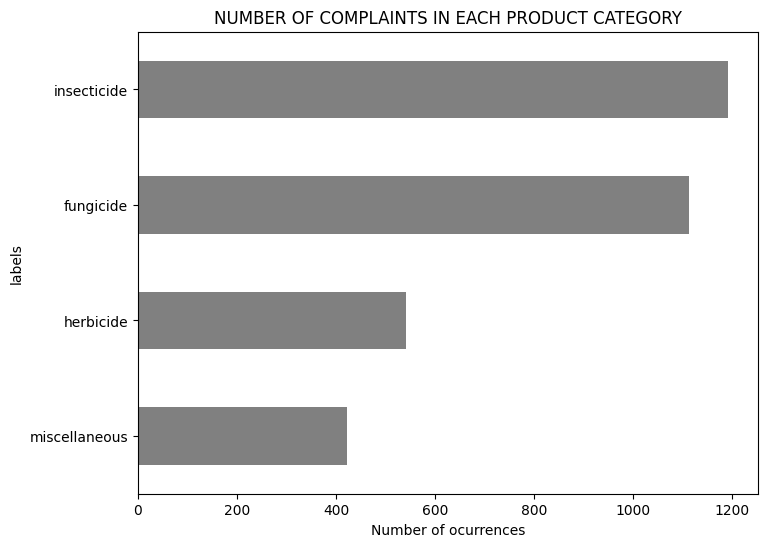

In [9]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','darkblue']
df1.groupby('labels').Title.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY')
plt.xlabel('Number of ocurrences', fontsize = 10)

In [10]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')
# We transform each complaint into a vector
features = tfidf.fit_transform(df1.Title).toarray()
labels = df1.category_id
print("Each of the %d Title is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 3267 Title is represented by 3047 features (TF-IDF score of unigrams and bigrams)


In [11]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

n==> fungicide:
  * Most Correlated Unigrams are: antifungal, fungal, antibacterial
  * Most Correlated Bigrams are: antibacterial agent, fungicidal composition, bactericidal composition


c:\Users\GhatkaP\.conda\envs\ML2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\GhatkaP\.conda\envs\ML2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


n==> herbicide:
  * Most Correlated Unigrams are: herbicidal, weeds, herbicide
  * Most Correlated Bigrams are: herbicide composition, controlling weeds, herbicidal composition
n==> insecticide:
  * Most Correlated Unigrams are: pest, pests, insect
  * Most Correlated Bigrams are: pests comprises, insect pests, insecticidal composition
n==> miscellaneous:
  * Most Correlated Unigrams are: methods, method, thereof
  * Most Correlated Bigrams are: method thereof, uses thereof, preparation method


c:\Users\GhatkaP\.conda\envs\ML2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\GhatkaP\.conda\envs\ML2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
X = df1['Title'] # Collection of documents
y = df1['labels'] # Target or the labels we want to predict 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.45,
                                                    random_state = 0)

In [13]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [14]:
# 5 Cross-validation
CV = 300
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [15]:
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [16]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.800606,0.131169
LogisticRegression,0.797606,0.127347
MultinomialNB,0.753727,0.139555
RandomForestClassifier,0.624667,0.125445


In [17]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df1.index, test_size=0.35, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [18]:
# Classification report
print('ttttCLASSIFICATIION METRICSn')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df1['labels'].unique()))

ttttCLASSIFICATIION METRICSn
               precision    recall  f1-score   support

  insecticide       0.75      0.82      0.78       421
    herbicide       0.84      0.69      0.76       196
    fungicide       0.76      0.77      0.77       380
miscellaneous       0.87      0.80      0.84       147

     accuracy                           0.78      1144
    macro avg       0.81      0.77      0.79      1144
 weighted avg       0.78      0.78      0.78      1144



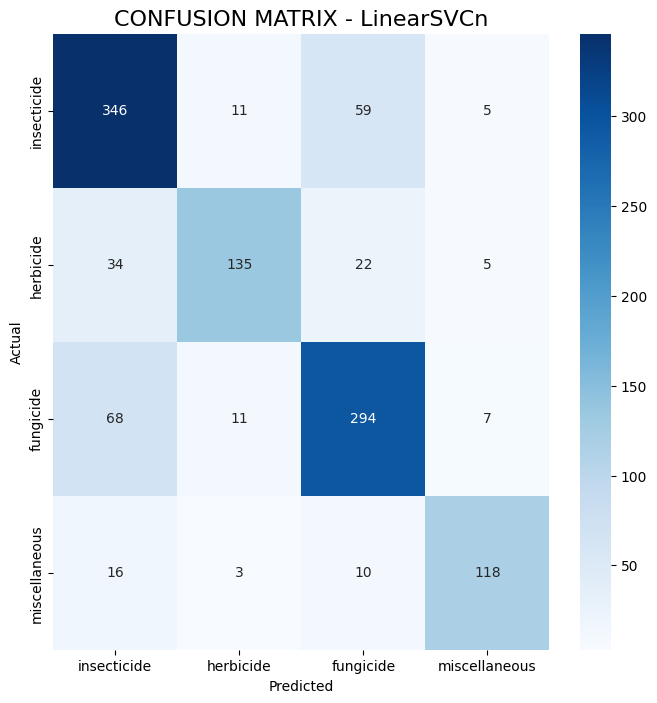

In [19]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.labels.values, 
            yticklabels=category_id_df.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVCn", size=16);

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [21]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

In [22]:
fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

In [23]:
model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [25]:
complaint ="Insecticide and acaricide paints that inhibit chitin synthesis, regulate insect juvenile hormone and repel arthropods, for controlling endemic diseases, pests and allergens"
print(model.predict(fitted_vectorizer.transform([complaint])))

['insecticide']


In [26]:
df2 = pd.read_excel(r"C:\Users\GhatkaP\Downloads\Test data for classifier.xlsx")
df2.columns

Index(['FAN', 'FAMILY_PN', 'FAMILY_PR', 'FID', 'PN', 'PR', 'IN', 'FPA', 'TI',
       'AB', 'CLMS', 'IC', 'CPC'],
      dtype='object')

In [28]:
df2['Labels'] = model.predict(fitted_vectorizer.transform(df2['TI']))

In [30]:
df2.to_excel("label_predict.xlsx")